# CIS4930: Introduction to Multimodal Machine Learning in Python

## Individual Coding Assignment 03

## Importing all libraries

In [12]:
import librosa
import os 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

## Step 1: Setting Data Frame and splitting it into training and testing dataset

In [13]:
def split_train_test(emotion):
    # Go to where all audio data is
    path = "./data_folder/" + emotion

    # Get a list of all the audio files in the directory
    audio_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]

    # Split the audio files into training and testing sets
    train_files, test_files = train_test_split(audio_files, test_size=0.3, random_state=42)

    return(train_files, test_files)

# Split audio files for each emotion
angry_train, angry_test = split_train_test('angry')
happy_train, happy_test = split_train_test('happy')
sad_train, sad_test = split_train_test('sad')
fear_train, fear_test = split_train_test('fear')


## Step 2: Exploratory Data Analysis

Angry:


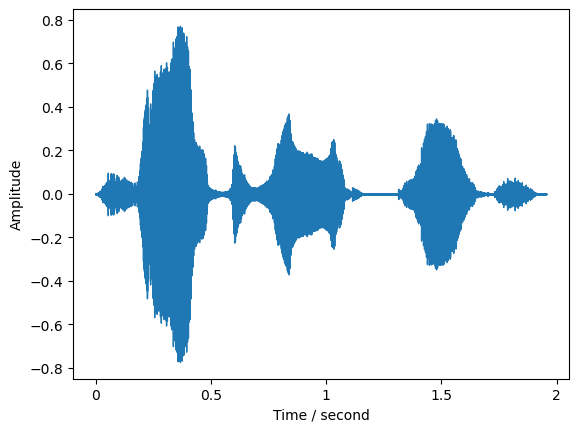

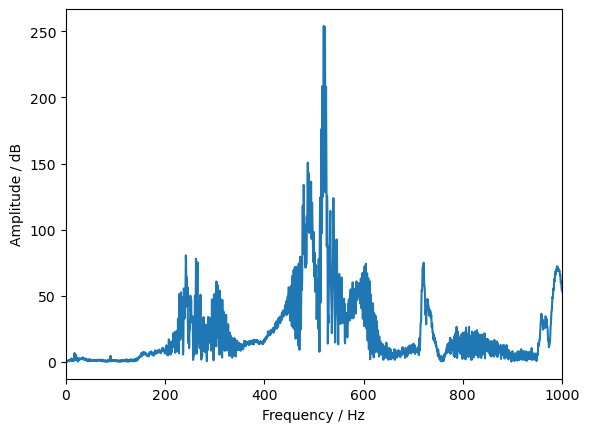

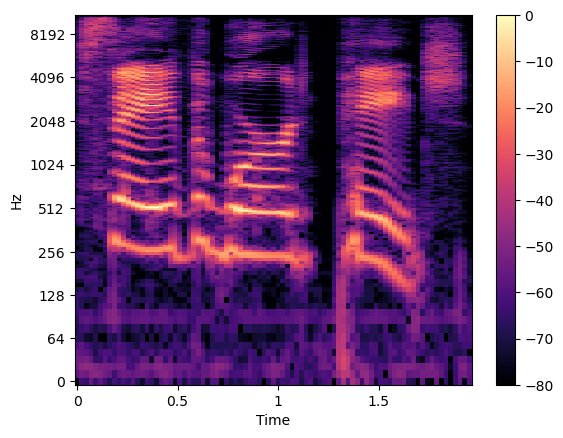

Fear:


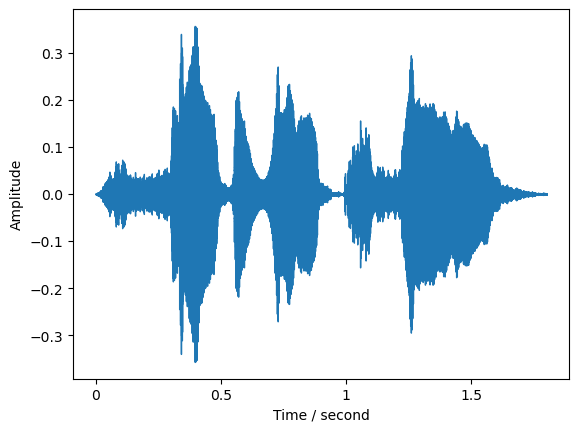

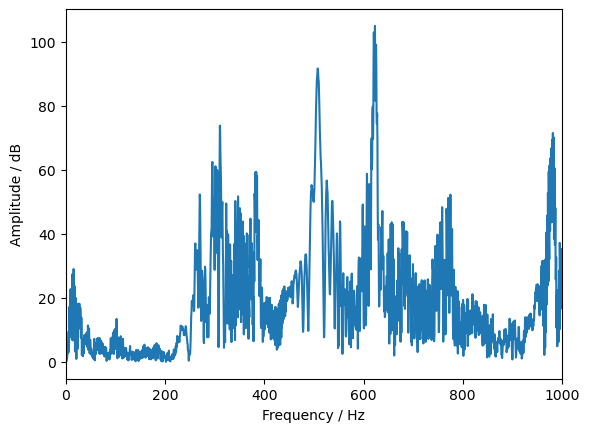

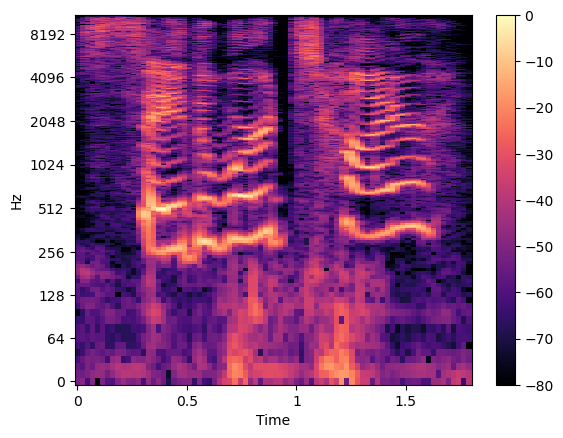

Happy:


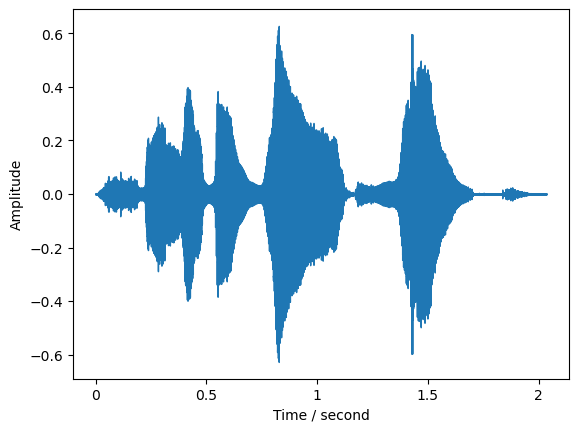

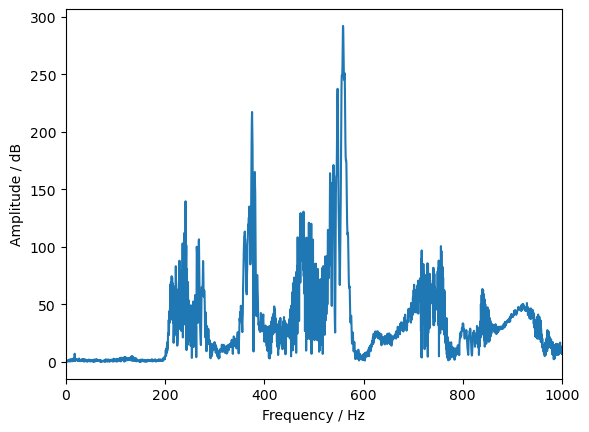

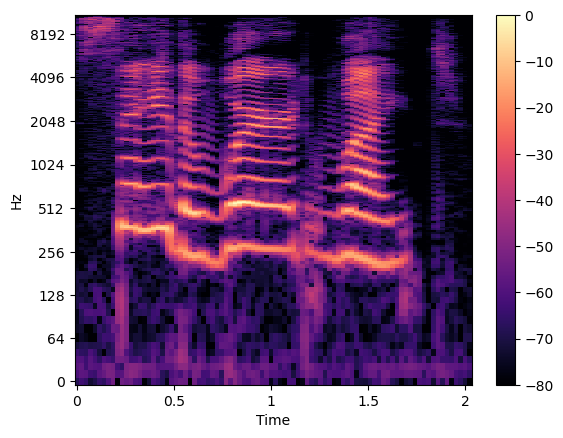

Sad:


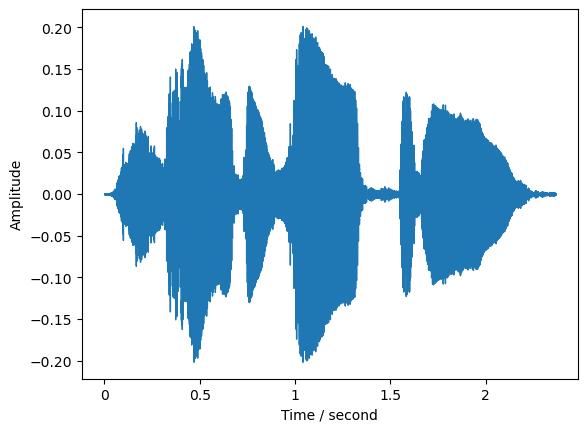

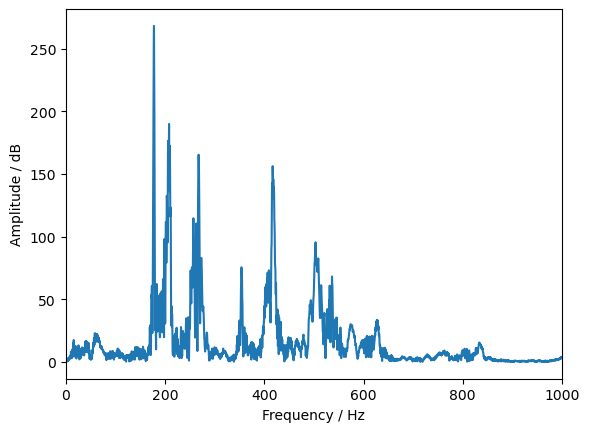

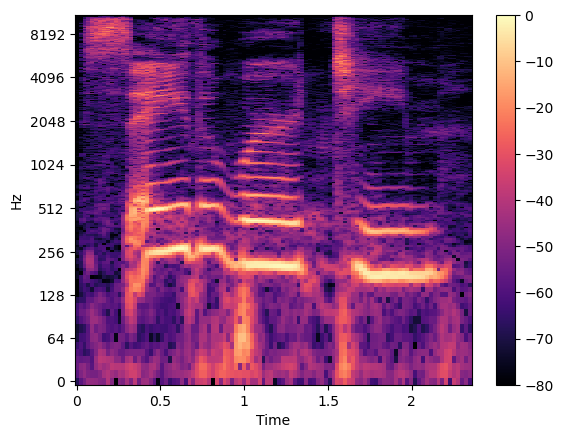

In [14]:
def plot_random_audio_file(folder_path):
    #Loads in all audio file and takes a random file from it
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    random_file = random.choice(audio_files)

    #Uses correct data path for librosa loading 
    audio_file_path = os.path.join(folder_path, random_file)
    signal, sample_rate = librosa.load(audio_file_path)

    #plots audio in time domain
    plt.figure()
    librosa.display.waveshow(y=signal, sr=sample_rate)
    plt.xlabel('Time / second')
    plt.ylabel('Amplitude')
    plt.show()

    #plots audio in frequency domain
    k = np.arange(len(signal))
    T = len(signal)/sample_rate
    freq = k/T

    #visualize the frequency spectrum of a signal
    DATA_0 = np.fft.fft(signal)
    abs_DATA_0 = abs(DATA_0)
    plt.figure(2)
    plt.plot(freq, abs_DATA_0)
    plt.xlabel("Frequency / Hz")
    plt.ylabel("Amplitude / dB")
    plt.xlim([0, 1000])
    plt.show()

    # plot the time-frequency variation of the audio
    D = librosa.stft(signal)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(3)
    librosa.display.specshow(S_db, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()

#Prints out result of random audio file from each emotion
print ("Angry:", end="\n")
plot_random_audio_file('data_folder/angry')
print ("Fear:", end="\n")
plot_random_audio_file('data_folder/fear')
print ("Happy:", end="\n")
plot_random_audio_file('data_folder/happy')
print ("Sad:", end="\n")
plot_random_audio_file('data_folder/sad')


## Step 3: Acoustic Feature Extraction

### Combined all dataframes into one so easier to extract features

In [15]:
train_all = np.concatenate((angry_train, happy_train, sad_train, fear_train))
test_all = np.concatenate((angry_test, happy_test, sad_test, fear_test))

In [22]:
def extract_features(audio_files):
    # List to store all feature matrices of certain emotion
    matrix = []
    
    # Iterate through all the audio files
    for audio in audio_files:
        signal, sample_rate = librosa.load(audio)

        # audio feature extraction

        #Loudness
        rms = librosa.feature.rms(S=librosa.magphase(librosa.stft(signal))[0])

        #MFCCS (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12).T

        #Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=signal)

        #Chroma
        chromagram = librosa.feature.chroma_stft(y=signal, sr=sample_rate).T

        #Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12).T
        
        # Combines and stores all features into a single feature matrix
        feature_matrix = pd.DataFrame({
            #Loudness column for data
            'Loudness': rms[0],

            #Creates a dictionary with keys like MFCC_1, MFCC_2, etc.
            #Then unpacks it into a single dictionary to be put into the matrix
            #When done, it should have multiple columns cooresponding with each key
            **{f'MFCC_{n+1}': mfccs[:,n] for n in range(mfccs.shape[1])},

            #Zero crossing rate
            'ZCR': zcr[0],

            #Same thing done with MFCC is for Chroma also
            **{f'Chroma_{n+1}': chromagram[:,n] for n in range(chromagram.shape[1])},

            #Same thing but with mel_spectrogram
            **{f'Mel_Spectrogram_{n+1}': mel_spectrogram[:,n] for n in range(mel_spectrogram.shape[1])}
        })
        
        feature_matrix.to_csv('testing.csv')

        # Scale the feature matrix using a MinMaxScaler object
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_data = scaler.fit_transform(feature_matrix)
        scaled_df = pd.DataFrame(scaled_data, columns=feature_matrix.columns)
        
        # Compute the mean of each column and append to the list of feature matrices
        matrix.append(scaled_df.mean().to_numpy())
    
    return matrix

# Extract all features for each training emotion
X_train = extract_features(train_all)
# print(X_train)

# Extract all features for each training emotion
X_test = extract_features(test_all)
# print(X_test)


## Step 4: Feature Post-Processing

### Setting up testing data for the model

In [17]:
# FOR REFERENCE 
# 0 = ANGRY
# 1 = HAPPY
# 2 = SAD
# 3 = FEAR

# Create array with training result
size_zero = np.zeros(len(angry_train))
size_one = np.ones(len(happy_train))
size_two = np.full(len(sad_train), 2)
size_three = np.full(len(fear_train), 3)

y_train = np.concatenate((size_zero, size_one, size_two, size_three))
#Double check to make sure there are proper amounts of values
print(y_train)

# Create array with training result
size_zero = np.zeros(len(angry_test))
size_one = np.ones(len(happy_test))
size_two = np.full(len(sad_test), 2)
size_three = np.full(len(fear_test), 3)

y_test = np.concatenate((size_zero, size_one, size_two, size_three))
#Double check to make sure there are proper amounts of values
print(y_test)



[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 

## Step 5: Building Your Audio Emotion Recognition Model

In [18]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, classification_report

In [19]:
svc = SVC(probability=True)
nbc = GaussianNB()
rfc = RandomForestClassifier()

svc.fit(X_train, y_train)
nbc.fit(X_train, y_train)
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
# Training complete, test your model with testing dataset
y_svc_predicted = svc.predict(X_test)
y_svc_pred_proba = svc.predict_proba(X_test)

y_nbc_predicted = nbc.predict(X_test)
y_nbc_pred_proba = nbc.predict_proba(X_test)

y_rfc_predicted = rfc.predict(X_test)
y_rfc_pred_proba = rfc.predict_proba(X_test)

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95        30
         1.0       1.00      0.97      0.98        30
         2.0       1.00      0.97      0.98        30
         3.0       0.94      0.97      0.95        30

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        30
         1.0       1.00      0.97      0.98        30
         2.0       0.97      1.00      0.98        30
         3.0       0.97      0.93      0.95        30

    accuracy                           0.97       120
   macro avg       0.98      0.98      0.97       120
weighted avg       0.98      0.97      0.97       120

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98        30
         1.0       1.

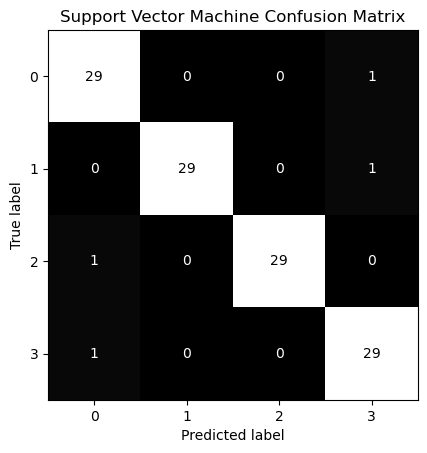

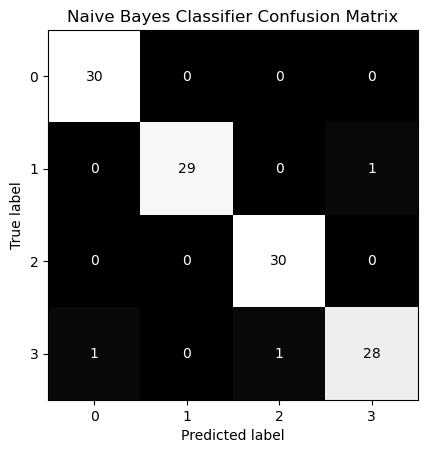

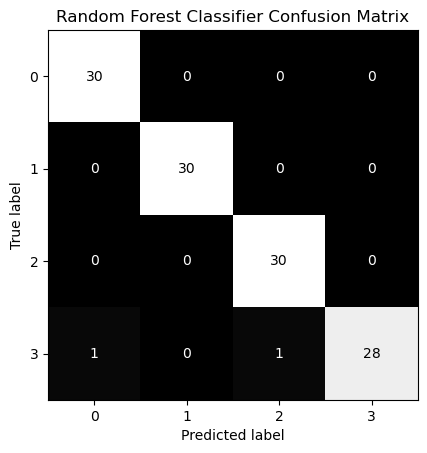

In [21]:
# Model evaluation with confusion matrix and ROC curve (like the previous assignment)
print(classification_report(y_test, y_svc_predicted))
print(classification_report(y_test, y_nbc_predicted))
print(classification_report(y_test, y_rfc_predicted))

models = ['Support Vector Machine', 'Naive Bayes Classifier', 'Random Forest Classifier']
predictions = [y_svc_predicted, y_nbc_predicted, y_rfc_predicted]
pred_probabilities = [y_svc_pred_proba, y_nbc_pred_proba, y_rfc_pred_proba]

plot = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"{model} Confusion Matrix")